## Minimalistic Growing Neural CA (w/ TF)

supplementary for NCA from scratch [video tutorial](https://www.youtube.com/watch?v=8EN_8p9Toyc)

In [2]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm
from tqdm.notebook import trange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_tmp.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_tmp.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-091501e4-40cd-fbb8-1cbb-72127397114f)


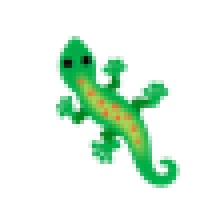

In [3]:
#@title {vertical-output: true}
TARGET_EMOJI = "🦎"
TARGET_SIZE = 40

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return imread(url, TARGET_SIZE)

def to_rgb(img):
  '''Convert premultiplied alpha RGBA to RGB on white.'''
  rgb, a = img[...,:3], img[...,3:4]
  return 1.0-a+rgb


target = load_emoji(TARGET_EMOJI)
target[...,:3] *= target[...,3:]
target = np.pad(target, [(8, 8), (8, 8), (0, 0)])

imshow(zoom(to_rgb(target)))

In [4]:
CHN = 16

h, w = target.shape[:2]
seed = np.zeros([1, h, w, CHN], np.float32)
seed[:,h//2, w//2, 3:] = 1.0

from tensorflow.keras.layers import Conv2D

def pad_repeat(x, pad=1):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  return x

@tf.function
def perceive(x, angle=0.0):
  identify = np.float32([0, 1, 0])
  identify = np.outer(identify, identify)
  dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
  dy = dx.T
  c, s = tf.cos(angle), tf.sin(angle)
  kernel = tf.stack([c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
  kernel = tf.repeat(kernel, x.shape[-1], 2)
  y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'VALID')
  return y


def get_living_mask(x):
  alpha = x[..., 3:4]
  return tf.cast(tf.nn.max_pool2d(alpha, 3, 1, 'SAME') >= 0.1, tf.float32)


class CA(tf.Module):
  def __init__(self):
    self.w1 = tf.Variable(tf.random.normal([CHN*3, 128])/np.sqrt(128))
    self.b1 = tf.Variable(tf.zeros([128]))
    self.w2 = tf.Variable(tf.zeros([128, CHN]))

  @tf.function
  def __call__(self, x):
    alive_mask = get_living_mask(x)
    update_mask = tf.floor(tf.random.uniform(x[...,:1].shape) + 0.5)
    y = perceive(pad_repeat(x))
    y = tf.concat([x, y], -1)
    y = tf.nn.relu(y@self.w1 + self.b1)@self.w2
    x += y*update_mask
    x *= alive_mask
    return x, y


In [5]:
ca = CA()
loss_log = []

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000], [2e-3, 2e-4])
trainer = tf.optimizers.Adam(lr)

def loss_f(x):
  img_loss = tf.reduce_mean(tf.square(x[...,:4]-target))
  return img_loss

pool = np.repeat(seed, 1024, 0)

@tf.function
def train_step(x):
  with tf.GradientTape() as g:
    step_n = 100
    if pool is not None:
      step_n = tf.random.uniform([], 32, 64, tf.int32)
    for i in tf.range(step_n):
      x, _ = ca(x)
    loss = loss_f(x)
  params = g.watched_variables()
  grads = g.gradient(loss, params)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, params))
  return loss, x

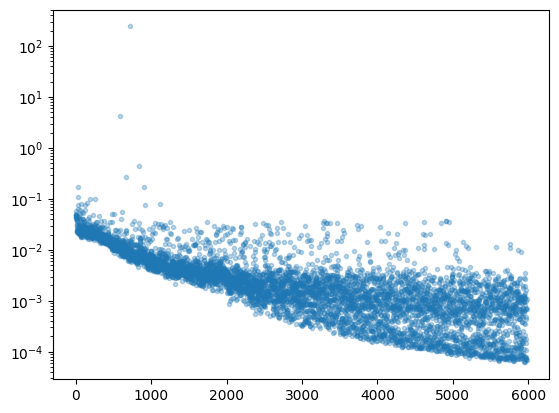

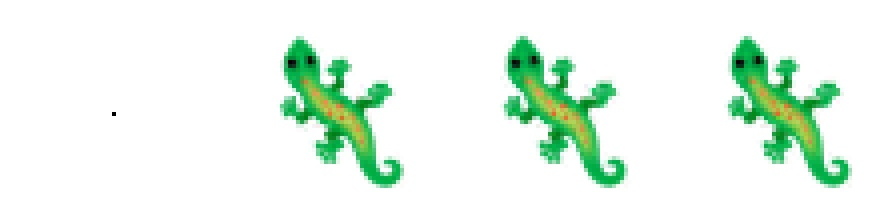

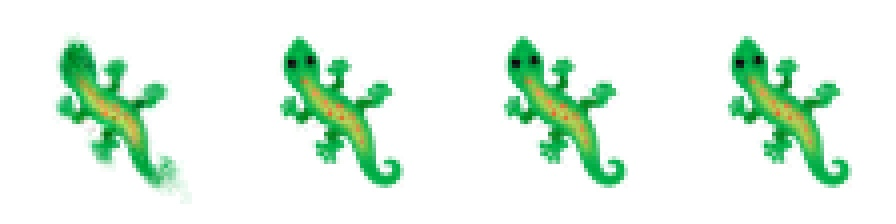

5981 0.0006904858


In [6]:
#@title Train loop {vertical-output: true}
for i in range(6000):
  if pool is not None:
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x0 = pool[batch_idx]
    if i%2 == 0:
      x0[:1] = seed
    loss, x = train_step(x0)
    pool[batch_idx] = x
  else:
    x0 = np.repeat(seed, 4, 0)
    loss, x = train_step(x0)
  loss_log.append(loss.numpy())
  if i%20 == 0:
    clear_output(True)
    pl.plot(loss_log, '.', alpha=0.3)
    pl.yscale('log')
    pl.show()
    imshow(zoom(np.hstack(to_rgb(x0))))
    imshow(zoom(np.hstack(to_rgb(x))))
    print(len(loss_log), loss.numpy(), flush=True)


In [7]:
def run_ca(ca, x=seed, iter_n=1000):
  with VideoWriter() as vid:
    for i in trange(iter_n, leave=False):
      vid.add(zoom(to_rgb(x[0])))
      x, _ = ca(x)

run_ca(ca)

  0%|          | 0/1000 [00:00<?, ?it/s]